# Linear Regression for the prediction of energy consumption data over 48 hours
### 1 - Linear Regression with Energy consumption data and weather data
### 2 - Linear Regression with Energy consumption data and 2 variables 'Lastgang_Moving_Average' and 'Lastgang_First_Difference'
### 3 - Linear Regression with Energy consumption data and 2 variables 'Hour' and 'DayOfWeek'

In [1]:
#Install all required packages with 'conda install NAME' or with pip install NAME'
# pandas
# numpy
# matplotlib
# scikit-learn
# pmdarima
# statsmodels

In [2]:
#Import all required libraries
import sys  # Provides access to some variables used or maintained by the interpreter
import pandas as pd # Library for data manipulation and analysis, ideal for working with structured data like tables
import numpy as np # For scientific computing, supports large, multi-dimensional arrays and matrices
import matplotlib.pyplot as plt # For creating static, interactive, and animated visualizations
import matplotlib.dates as mdates # For handling date formatting in plots
from sklearn.preprocessing import MinMaxScaler # For scaling and normalizing features, often useful in data preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error # For calculating common statistical metrics to evaluate models
import statsmodels.api as sm # Provides classes and functions for the estimation of many different statistical models
from sklearn.preprocessing import MinMaxScaler #To use MinMaxScaler to normalize and scale continuous numerical data

In [3]:
#To display the current environment
print(sys.executable)

/home/sarah/anaconda3/envs/BT2024SARIMAModel/bin/python


In [4]:
# Step 1 - Reading Data

## dfClimaAll: Data from 2021-2023
## dfEnergyAll: All data from the transformer station from 2021-2023

# Load data for 2021
dfClima21 = pd.read_excel('/home/sarah/Documents/BT2024/Weather_Data/2021TimeWeather.xlsx')

# Load data for 2022
dfClima22 = pd.read_excel('/home/sarah/Documents/BT2024/Weather_Data/2022TimeWeather.xlsx')

# Load data for 2023
dfClima23 = pd.read_excel('/home/sarah/Documents/BT2024/Weather_Data/2023TimeWeather.xlsx')

# Merge the DataFrames
dfClimaAll = pd.concat([dfClima21, dfClima22, dfClima23])

# Check the resulting DataFrame
print("First and last rows from dfClimaAll:")
print(dfClimaAll.head())
print(dfClimaAll.tail())

# Check for missing values in each column
## .isnull(): Returns DF where values with NaN are replaced by True & values without NaN are replaced by False
## sum(): Sums up the number of True values
print("Number of missing values per column:")
print(dfClimaAll.isnull().sum())

# Convert 'Timestamp' into a Datetime object and set it as index, if not already set
if 'TimestampWeather' in dfClimaAll.columns:
    ## pd.to_datetime: Converts values into Datetime objects —> Pandas can then treat these as timestamps
    dfClimaAll['TimestampWeather'] = pd.to_datetime(dfClimaAll['TimestampWeather'])
    ## set_index: Sets index for the Timestamp column to facilitate access to data based on time points
    dfClimaAll = dfClimaAll.set_index('TimestampWeather')

# Number of rows in dfClimaAll
print("Number of rows in dfClimaAll:", dfClimaAll.shape[0])


First and last rows from dfClimaAll:
   dy  Globalstrahlung_15Min  Sonnenhöhe  ExtraterrestrischeStrahlung  \
0   1                      0       -65.0                            0   
1   1                      0       -65.0                            0   
2   1                      0       -65.4                            0   
3   1                      0       -65.5                            0   
4   1                      0       -65.2                            0   

   StundenwertStrahlung  Diffusstrahlung  StrahlungGeneigteFläche  \
0                     0                0                        0   
1                     0                0                        0   
2                     0                0                        0   
3                     0                0                        0   
4                     0                0                        0   

   DiffusstrahlungGeneigteFläche  Direktnormalstrahlung  Lufttemperatur  \
0                              0  

In [5]:
# Step 1 - Reading Data

## dfClimaAll: Data from 2021-2023
## dfEnergyAll: All data from the transformer station from 2021-2023

from pathlib import Path

# Path to the directory containing the Excel files
directory_path = Path('/home/sarah/Documents/BT2024/All')

# Create a list of all Excel files in the directory
file_paths = list(directory_path.glob('*.xlsx'))

# List to store the individual DataFrames
dfs = []

# Loop over all file paths
for file_path in file_paths:
    # Read the Excel file
    df = pd.read_excel(file_path)
    
    # Convert the 'Timestamp' column to a datetime
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Convert the 'Lastgang' column to a numeric type, treat errors as NaN
    df['Lastgang'] = pd.to_numeric(df['Lastgang'], errors='coerce')
    
    # Sort the DataFrame by 'Timestamp'
    df = df.sort_values(by='Timestamp')
    
    # Perform linear interpolation for 'Lastgang' on the individual DataFrame
    df['Lastgang'] = df['Lastgang'].interpolate(method='linear')
    
    # Add the DataFrame to the list
    dfs.append(df)

# Merge all DataFrames in the list
dfEnergyAll = pd.concat(dfs).set_index('Timestamp')

# Sum the 'Lastgang' values for identical timestamps
dfEnergyAll = dfEnergyAll.groupby('Timestamp').sum()

# Check the resulting DataFrame
print("First and last rows from dfEnergyAll:")
print(dfEnergyAll.head())
print(dfEnergyAll.tail())

# Display the number of rows in dfEnergyAll
print("Number of rows in dfEnergyAll:", dfEnergyAll.shape[0])

First and last rows from dfEnergyAll:
                     Lastgang
Timestamp                    
2021-01-01 00:00:00    472.88
2021-01-01 00:15:00    498.83
2021-01-01 00:30:00    480.48
2021-01-01 00:45:00    446.74
2021-01-01 01:00:00    459.55
                     Lastgang
Timestamp                    
2023-12-31 22:45:00    833.17
2023-12-31 23:00:00    767.89
2023-12-31 23:15:00    770.04
2023-12-31 23:30:00    730.45
2023-12-31 23:45:00    744.21
Number of rows in dfEnergyAll: 105108


In [6]:
# Step 2 - Preparing the Data

# Create a complete timestamp index for the years 2021 - 2023 in 15-minute intervals
all_timestamps = pd.date_range(start='2021-01-01 00:00:00', end='2023-12-31 23:45:00', freq='15T')

# Convert this into a DataFrame
df_all_timestamps = pd.DataFrame(all_timestamps, columns=['Timestamp'])
df_all_timestamps = df_all_timestamps.set_index('Timestamp')

# Compare the complete timestamp index with dfEnergyAll
missing_timestamps = df_all_timestamps.index.difference(dfEnergyAll.index)

print("Missing timestamps in dfEnergyAll:")
print(missing_timestamps)


# Missing timestamps
missing_timestamps = pd.DatetimeIndex(['2021-03-28 02:00:00', '2021-03-28 02:15:00',
                                       '2021-03-28 02:30:00', '2021-03-28 02:45:00',
                                       '2022-03-27 02:00:00', '2022-03-27 02:15:00',
                                       '2022-03-27 02:30:00', '2022-03-27 02:45:00',
                                       '2023-03-26 02:00:00', '2023-03-26 02:15:00',
                                       '2023-03-26 02:30:00', '2023-03-26 02:45:00'])

# Create a DataFrame with the missing timestamps
df_missing = pd.DataFrame(index=missing_timestamps)

# Merge this DataFrame with the original DataFrame
dfEnergyAll = dfEnergyAll.combine_first(df_missing)

# Fill the missing values. Use 'ffill' for forward fill.
dfEnergyAll = dfEnergyAll.sort_index().fillna(method='ffill')

print("Check after adding the missing timestamps:")
print(dfEnergyAll.loc[missing_timestamps])

# Number of rows in dfClima21
# Ensure dfClima21 is already defined before executing this line.
print("Number of rows in dfClima21:", dfClimaAll.shape[0])

# Number of rows in dfEnergyAll
print("Number of rows in dfEnergyAll:", dfEnergyAll.shape[0])

Missing timestamps in dfEnergyAll:
DatetimeIndex(['2021-03-28 02:00:00', '2021-03-28 02:15:00',
               '2021-03-28 02:30:00', '2021-03-28 02:45:00',
               '2022-03-27 02:00:00', '2022-03-27 02:15:00',
               '2022-03-27 02:30:00', '2022-03-27 02:45:00',
               '2023-03-26 02:00:00', '2023-03-26 02:15:00',
               '2023-03-26 02:30:00', '2023-03-26 02:45:00'],
              dtype='datetime64[ns]', name='Timestamp', freq=None)
Check after adding the missing timestamps:
                     Lastgang
2021-03-28 02:00:00    372.28
2021-03-28 02:15:00    372.28
2021-03-28 02:30:00    372.28
2021-03-28 02:45:00    372.28
2022-03-27 02:00:00    554.20
2022-03-27 02:15:00    554.20
2022-03-27 02:30:00    554.20
2022-03-27 02:45:00    554.20
2023-03-26 02:00:00    520.34
2023-03-26 02:15:00    520.34
2023-03-26 02:30:00    520.34
2023-03-26 02:45:00    520.34
Number of rows in dfClima21: 105120
Number of rows in dfEnergyAll: 105120


/tmp/ipykernel_117485/1871761932.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dfEnergyAll = dfEnergyAll.sort_index().fillna(method='ffill')


## 1 - Linear Regression with Energy consumption data and weather data

In [7]:
# Step 2 - Preparing the Data

# To check if the indexes in both DataFrames are set equally
dfClimaAll.index.equals(dfEnergyAll.index)

# Adding the columns from dfClima21 to dfEnergyAll
dfEnergyAll = dfEnergyAll.join(dfClimaAll[['StundenwertStrahlung', 'Globalstrahlung_15Min', 'StrahlungGeneigteFläche', 'TheorPVProd', 'Direktnormalstrahlung', 'Schönwetterstrahlung', 'Lufttemperatur']])

# Checking for missing values in each column
print("Number of missing values per column:")
print(dfEnergyAll.isnull().sum())

# Printing the first and last rows from the dataframe
print("First and last rows from dfEnergyAll-Edited:")
print(dfEnergyAll.head())
print(dfEnergyAll.tail())

Number of missing values per column:
Lastgang                   0
StundenwertStrahlung       0
Globalstrahlung_15Min      0
StrahlungGeneigteFläche    0
TheorPVProd                0
Direktnormalstrahlung      0
Schönwetterstrahlung       0
Lufttemperatur             0
dtype: int64
First and last rows from dfEnergyAll-Edited:
                     Lastgang  StundenwertStrahlung  Globalstrahlung_15Min  \
2021-01-01 00:00:00    472.88                     0                      0   
2021-01-01 00:15:00    498.83                     0                      0   
2021-01-01 00:30:00    480.48                     0                      0   
2021-01-01 00:45:00    446.74                     0                      0   
2021-01-01 01:00:00    459.55                     0                      0   

                     StrahlungGeneigteFläche  TheorPVProd  \
2021-01-01 00:00:00                        0            0   
2021-01-01 00:15:00                        0            0   
2021-01-01 00:30:00  

In [8]:
# Step 2 - Preparing the Data

# Calculating the moving average for 'Lastgang'
window_size = 96  # This corresponds to 24 hours at 15-minute intervals
dfEnergyAll['Lastgang_Moving_Average'] = dfEnergyAll['Lastgang'].rolling(window=window_size).mean()

# Calculating the first differences for 'Lastgang'
dfEnergyAll['Lastgang_First_Difference'] = dfEnergyAll['Lastgang'].diff()

# Since the first `window_size - 1` values of the moving average will be NaN and the first value of the first difference will be NaN, fill these values.
dfEnergyAll = dfEnergyAll.fillna(method='bfill')

# To check the first few rows to ensure the new features look as expected.
print(dfEnergyAll.head())

                     Lastgang  StundenwertStrahlung  Globalstrahlung_15Min  \
2021-01-01 00:00:00    472.88                     0                      0   
2021-01-01 00:15:00    498.83                     0                      0   
2021-01-01 00:30:00    480.48                     0                      0   
2021-01-01 00:45:00    446.74                     0                      0   
2021-01-01 01:00:00    459.55                     0                      0   

                     StrahlungGeneigteFläche  TheorPVProd  \
2021-01-01 00:00:00                        0            0   
2021-01-01 00:15:00                        0            0   
2021-01-01 00:30:00                        0            0   
2021-01-01 00:45:00                        0            0   
2021-01-01 01:00:00                        0            0   

                     Direktnormalstrahlung  Schönwetterstrahlung  \
2021-01-01 00:00:00                      0                     0   
2021-01-01 00:15:00         

/tmp/ipykernel_117485/1800522370.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dfEnergyAll = dfEnergyAll.fillna(method='bfill')


In [9]:
# Step 3 - Data Scaling

# Initialize the scalers
lastgang_scaler = MinMaxScaler(feature_range=(0, 1))
features_scaler = MinMaxScaler(feature_range=(0, 1))

# Apply the scaler to the corresponding columns
dfEnergyAll['Lastgang'] = lastgang_scaler.fit_transform(dfEnergyAll['Lastgang'].values.reshape(-1, 1))
dfEnergyAll[['StundenwertStrahlung', 'Lufttemperatur', 'Globalstrahlung_15Min', 'StrahlungGeneigteFläche', 'Lastgang_Moving_Average', 'Lastgang_First_Difference']] = features_scaler.fit_transform(dfEnergyAll[['StundenwertStrahlung', 'Lufttemperatur', 'Globalstrahlung_15Min', 'StrahlungGeneigteFläche', 'Lastgang_Moving_Average', 'Lastgang_First_Difference']])

In [10]:
# Step 4 - Creating the linear regression model and generating predictions

## Performing linear regression with energy consumption data and meteorological data from 2021-2023
# Splitting the data into training and testing sets
# The last 192 data points (48 hours at 15-minute intervals) are the test dataset
train = dfEnergyAll.iloc[:-192]
test = dfEnergyAll.iloc[-192:]

# Define the target and explanatory variables for training and testing
y_train = train['Lastgang']
X_train = train[['StundenwertStrahlung', 'Globalstrahlung_15Min', 'StrahlungGeneigteFläche', 'TheorPVProd', 'Direktnormalstrahlung', 'Schönwetterstrahlung', 'Lufttemperatur', 'Lastgang_Moving_Average', 'Lastgang_First_Difference']]
X_train = sm.add_constant(X_train)  # Adding a constant column to include the intercept in the model

y_test = test['Lastgang']
X_test = test[['StundenwertStrahlung', 'Globalstrahlung_15Min', 'StrahlungGeneigteFläche', 'TheorPVProd', 'Direktnormalstrahlung', 'Schönwetterstrahlung', 'Lufttemperatur', 'Lastgang_Moving_Average', 'Lastgang_First_Difference']]
X_test = sm.add_constant(X_test)  # Adding a constant column to include the intercept in the model

# Create and fit the model with training data
model = sm.OLS(y_train, X_train).fit()

# Generate predictions for the test data
predictions = model.predict(X_test)

# Output the summary of the model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               Lastgang   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                 1.119e+04
Date:                Mon, 29 Apr 2024   Prob (F-statistic):               0.00
Time:                        21:35:12   Log-Likelihood:                 82832.
No. Observations:              104928   AIC:                        -1.656e+05
Df Residuals:                  104919   BIC:                        -1.656e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

Mean Squared Error (MSE) for the last 48 hours: 29459.063725402957
Mean Absolute Error (MAE) for the last 48 hours: 144.12908664901138
Root Mean Square Error (RMSE) for the last 48 hours: 171.63642889958692
Mean Absolute Percentage Error (MAPE) for the last 48 hours: 19.288364449886654%


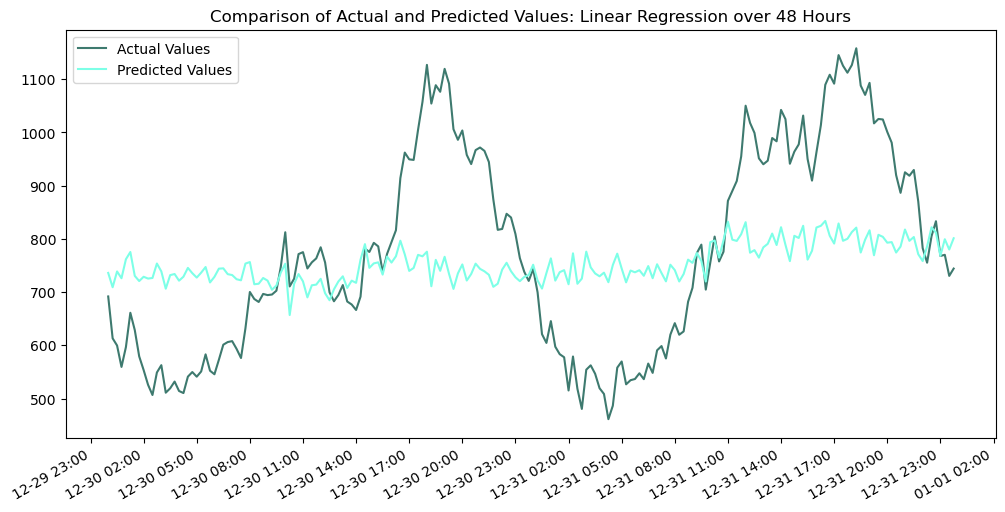

In [11]:
# Step 5 - Rescaling, error metrics and visualization

# Rescale predictions to the original scale
predictions_original_scale = lastgang_scaler.inverse_transform(predictions.to_numpy().reshape(-1, 1))

# Rescale actual values to the original scale
y_test_original_scale = lastgang_scaler.inverse_transform(y_test.to_numpy().reshape(-1, 1))

# Calculate error metrics for the test data (on the original scale)
mse = mean_squared_error(y_test_original_scale, predictions_original_scale)
mae = mean_absolute_error(y_test_original_scale, predictions_original_scale)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_original_scale - predictions_original_scale) / y_test_original_scale)) * 100

# Output error metrics
print(f"Mean Squared Error (MSE) for the last 48 hours: {mse}")
print(f"Mean Absolute Error (MAE) for the last 48 hours: {mae}")
print(f"Root Mean Square Error (RMSE) for the last 48 hours: {rmse}")
print(f"Mean Absolute Percentage Error (MAPE) for the last 48 hours: {mape}%")

# Visualization of actual vs. predicted values for the test data (original scale)
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test_original_scale, label='Actual Values', color='#3E7A6F')
plt.plot(y_test.index, predictions_original_scale, label='Predicted Values', color='#7DFFE7')
plt.legend()
plt.title('Comparison of Actual and Predicted Values: Linear Regression over 48 Hours')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=3))
plt.gcf().autofmt_xdate()
plt.show()



## 2 - Linear Regression with Energy consumption data and 2 variables 'Lastgang_Moving_Average' and 'Lastgang_First_Difference'

In [12]:
# Step 3 - Data Scaling

from sklearn.preprocessing import MinMaxScaler

# Initialize the scalers
lastgang_scaler = MinMaxScaler(feature_range=(0, 1))
features_scaler = MinMaxScaler(feature_range=(0, 1))

# Apply the scaler to the appropriate columns
dfEnergyAll['Lastgang'] = lastgang_scaler.fit_transform(dfEnergyAll['Lastgang'].values.reshape(-1, 1))
dfEnergyAll[['Lastgang_Moving_Average', 'Lastgang_First_Difference']] = features_scaler.fit_transform(dfEnergyAll[['Lastgang_Moving_Average', 'Lastgang_First_Difference']])


In [13]:
# Step 4 - Creating the linear regression model and generating predictions

## Performing linear regression with energy consumption data for the years 2021-2023
# Splitting the data into training and testing sets
# The last 192 data points (48 hours at 15-minute intervals) are the test dataset
train = dfEnergyAll.iloc[:-192]
test = dfEnergyAll.iloc[-192:]

# Define the target and explanatory variables for training and testing
y_train = train['Lastgang']
X_train = train[['Lastgang_Moving_Average', 'Lastgang_First_Difference']]
X_train = sm.add_constant(X_train)  # Adding a constant column to include the intercept in the model

y_test = test['Lastgang']
X_test = test[['Lastgang_Moving_Average', 'Lastgang_First_Difference']]
X_test = sm.add_constant(X_test)  # Adding a constant column to include the intercept in the model

# Create and fit the model with training data
model = sm.OLS(y_train, X_train).fit()

# Generate predictions for the test data
predictions = model.predict(X_test)

# Output the summary of the model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               Lastgang   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                 3.242e+04
Date:                Mon, 29 Apr 2024   Prob (F-statistic):               0.00
Time:                        21:35:12   Log-Likelihood:                 75701.
No. Observations:              104928   AIC:                        -1.514e+05
Df Residuals:                  104925   BIC:                        -1.514e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

Mean Squared Error (MSE) for the last 48 hours: 0.014205019585883332
Mean Absolute Error (MAE) for the last 48 hours: 0.10027292257737576
Root Mean Square Error (RMSE) for the last 48 hours: 0.11918481273167035
Mean Absolute Percentage Error (MAPE) for the last 48 hours: 21.170930519741667%


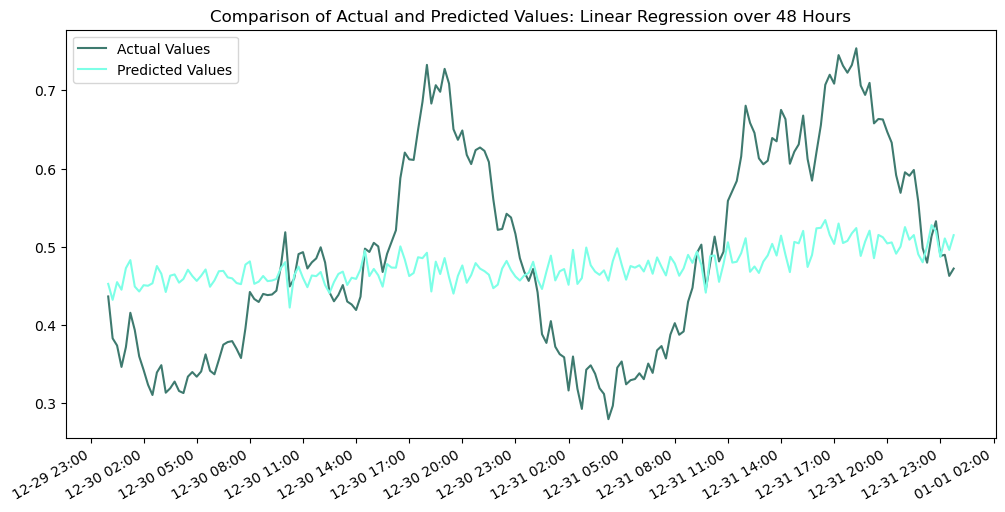

In [14]:
# Step 5 - Rescaling, error metrics and visualization

# Rescale predictions to the original scale
predictions_original_scale = lastgang_scaler.inverse_transform(predictions.to_numpy().reshape(-1, 1))

# Rescale actual values to the original scale
y_test_original_scale = lastgang_scaler.inverse_transform(y_test.to_numpy().reshape(-1, 1))

# Calculate error metrics for the test data (on the original scale)
mse = mean_squared_error(y_test_original_scale, predictions_original_scale)
mae = mean_absolute_error(y_test_original_scale, predictions_original_scale)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_original_scale - predictions_original_scale) / y_test_original_scale)) * 100

# Output error metrics
print(f"Mean Squared Error (MSE) for the last 48 hours: {mse}")
print(f"Mean Absolute Error (MAE) for the last 48 hours: {mae}")
print(f"Root Mean Square Error (RMSE) for the last 48 hours: {rmse}")
print(f"Mean Absolute Percentage Error (MAPE) for the last 48 hours: {mape}%")

# Visualization of actual vs. predicted values for the test data (original scale)
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test_original_scale, label='Actual Values', color='#3E7A6F')
plt.plot(y_test.index, predictions_original_scale, label='Predicted Values', color='#7DFFE7')
plt.legend()
plt.title('Comparison of Actual and Predicted Values: Linear Regression over 48 Hours')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=3))
plt.gcf().autofmt_xdate()
plt.show()


## 3 - Linear Regression with Energy consumption data and 2 variables 'Hour' and 'DayOfWeek'

In [15]:
# Step 3 - Backscaling & Variables

# Rescale 'Lastgang' data back to original scale
dfEnergyAll['Lastgang'] = lastgang_scaler.inverse_transform(dfEnergyAll['Lastgang'].values.reshape(-1, 1))

# Add time variables
dfEnergyAll['Hour'] = dfEnergyAll.index.hour
dfEnergyAll['DayOfWeek'] = dfEnergyAll.index.dayofweek

In [16]:
# Step 4 - Creating the linear regression model and generating predictions

# Split the data into training and testing sets
train = dfEnergyAll.iloc[:-192]
test = dfEnergyAll.iloc[-192:]

# Define target and explanatory variables (only Lastgang and time variables)
y_train = train['Lastgang']
X_train = train[['Hour', 'DayOfWeek']]
X_train = sm.add_constant(X_train)  # Adding a constant to include intercept

y_test = test['Lastgang']
X_test = test[['Hour', 'DayOfWeek']]
X_test = sm.add_constant(X_test)  # Adding a constant to include intercept

# Create and fit the model
model = sm.OLS(y_train, X_train).fit()

# Make predictions
predictions = model.predict(X_test)

# Output the summary of the model
print(model.summary())




                            OLS Regression Results                            
Dep. Variable:               Lastgang   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                 1.980e+04
Date:                Mon, 29 Apr 2024   Prob (F-statistic):               0.00
Time:                        21:35:13   Log-Likelihood:                 67258.
No. Observations:              104928   AIC:                        -1.345e+05
Df Residuals:                  104925   BIC:                        -1.345e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3011      0.001    312.011      0.0

Mean Squared Error (MSE) for the last 48 hours: 0.012474713729335092
Mean Absolute Error (MAE) for the last 48 hours: 0.08388706616321262
Root Mean Square Error (RMSE) for the last 48 hours: 0.11169025798759305
Mean Absolute Percentage Error (MAPE) for the last 48 hours: 15.012789192315386%


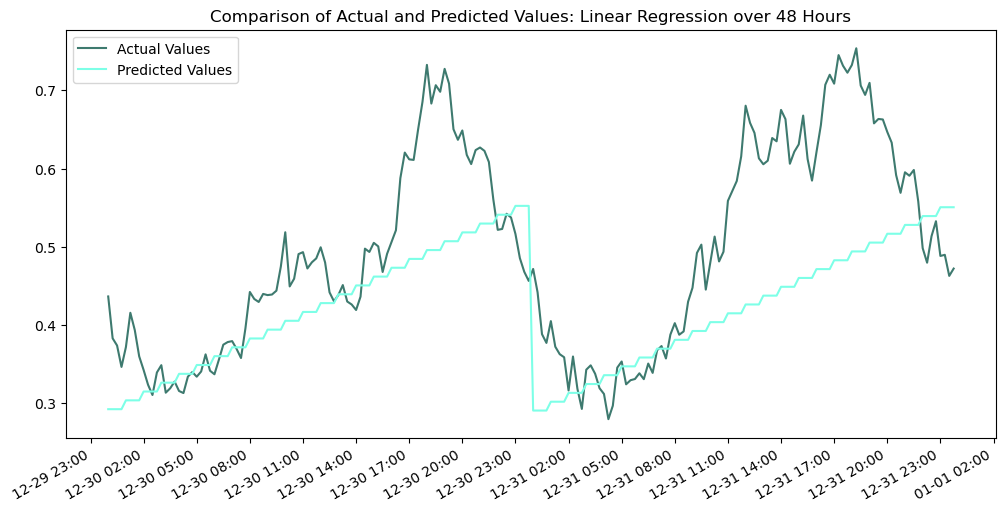

In [17]:
# Step 5 - Rescaling, error metrics and visualization

# Calculate error metrics
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

# Output error metrics
print(f"Mean Squared Error (MSE) for the last 48 hours: {mse}")
print(f"Mean Absolute Error (MAE) for the last 48 hours: {mae}")
print(f"Root Mean Square Error (RMSE) for the last 48 hours: {rmse}")
print(f"Mean Absolute Percentage Error (MAPE) for the last 48 hours: {mape}%")

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Values', color='#3E7A6F')
plt.plot(y_test.index, predictions, label='Predicted Values', color='#7DFFE7')
plt.legend()
plt.title('Comparison of Actual and Predicted Values: Linear Regression over 48 Hours')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=3))
plt.gcf().autofmt_xdate()
plt.show()